This notebook compares most of the objective functions mentioned in the recent paper at NEurIPS 2018 [On variational lower bounds of mutual information](http://bayesiandeeplearning.org/2018/papers/136.pdf) by [Ben Poole](https://cs.stanford.edu/~poole/) et al. to calculate Mutual Information using an implementation in PyTorch.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# data
np.random.seed(1234)
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

In [3]:
np.random.seed(1234)
data_size = 1000000
x = gen_x()
y = gen_y(x)

In [4]:
x = gen_x()
y = gen_y(x)
p_y_x = np.exp(-(y - x)**2 / (2 * var))
p_y_x_minus = np.exp(-(y + 1)**2 / (2 * var))
p_y_x_plus = np.exp(-(y - 1)**2 / (2 * var))
mi = np.average(np.log(p_y_x / (0.5 * p_y_x_minus + 0.5 * p_y_x_plus)))
#mi = mutual_information(x, y)
print("Mutual information calculated through traditional method is:", mi)

Mutual information calculated through traditional method is: 0.6584537102332939


In [5]:
np.random.seed(1234)
H=10
n_epoch = 500
data_size = 20000
e = 2.71828

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss_nwj = []
plot_loss_jsd = []
plot_loss_mine = []
plot_loss_nce = []


for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    # Nguyen Wainwright Jordan (NWJ)
    ret_nwj = torch.mean(pred_xy) - (1/e) * torch.mean(torch.exp(pred_x_y))
    # Jensen Shannon Divergence (JS) loss
    ret_jsd = torch.mean(-torch.log(1 + torch.exp(-pred_xy))) - torch.mean(torch.log(1 + torch.exp(pred_x_y))) + e - 1
    #ret_jsd = torch.mean(torch.log(1 + pred_xy)) - torch.mean(torch.log(pred_x_y))
    # Mutual Information Neural Estimation (MINE)/ Donsker Varadhan (DV) loss
    ret_mine = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    # Noise Contrastive Estimation(NCE) loss
    #ret_nce = torch.mean(pred_xy - torch.log(1 + pred_xy + torch.sum(torch.exp(pred_x_y))))
    ret_nce = torch.mean(pred_xy - torch.mean(torch.log(torch.sum(torch.exp(pred_x_y)))))
    
    loss_nwj = - ret_nwj  # maximize
    loss_jsd = - ret_jsd
    loss_mine = - ret_mine  # maximize
    loss_nce = - ret_nce  # maximize
    
    plot_loss_mine.append(loss_mine.data.numpy())
    plot_loss_jsd.append(loss_jsd.data.numpy())
    plot_loss_nwj.append(loss_nwj.data.numpy())
    plot_loss_nce.append(loss_nce.data.numpy())
    
    model.zero_grad()
    
    loss_nwj.backward(retain_graph=True)
    loss_jsd.backward(retain_graph=True)
    loss_mine.backward(retain_graph=True)
    loss_nce.backward(retain_graph=True)
    
    optimizer.step()

100%|██████████| 500/500 [00:11<00:00, 43.71it/s]


In [6]:
plot_x = np.arange(len(plot_loss_mine))
plot_y_nwj = np.array(plot_loss_nwj).reshape(-1,)
plot_y_jsd = np.array(plot_loss_jsd).reshape(-1,)
plot_y_mine = np.array(plot_loss_mine).reshape(-1,)
plot_y_nce = np.array(plot_loss_nce).reshape(-1,) - np.log(data_size)

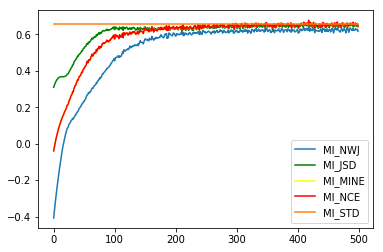

In [7]:
# plotting all together
plt.plot(plot_x, -plot_y_nwj)
plt.plot(plot_x, -plot_y_jsd, c = "green")
plt.plot(plot_x, -plot_y_mine, c = "yellow")
plt.plot(plot_x, -plot_y_nce, c = "red")
plt.plot(plot_x, mi*np.ones(len(plot_loss_mine)))
plt.legend(["MI_NWJ", "MI_JSD", "MI_MINE", "MI_NCE", "MI_STD"])
plt.show()

MINE and NCE almost coincide and hence, we don't see the yellow line.